In [1]:
using ForwardDiff
using Plots
using SimpleSolvers

using ForwardDiff

using LinearAlgebra
using LogExpFunctions, Distances
using WassersteinDictionaries

using Optim, LineSearches

In [2]:
const d = 2
const n = 32

x₁ = collect(range(0,1,length=n))
x₂ = collect(range(0,1,length=n));

In [3]:
c = WassersteinDictionaries.get_cost_matrix_separated(n, d);

In [19]:
t = 0.01:0.1:1
a = 0.8/sqrt(2)
ν = range(0.0001,0.001,length=5)

function _p(x,t,a,ν)
    x₀ = [0.25; 0.25] + t*a*[1; 1]
    σ = sqrt(0.001 + 2*t*ν)
    
    1/(2*pi*σ^2) * exp(-norm(x - x₀)^2/(2*σ^2))
end

Sₜ = length(t)*length(a)*length(ν)

50

In [20]:
length(ν)

5

In [21]:
p = [zeros(n,n) for _ in 1:Sₜ] # input histograms

for r in 1:length(ν)
    for s in 1:length(t)
        idx = s + (r-1)*length(t)
        for i in 1:n
            for j in 1:n
                p[idx][i,j] = _p([x₁[i]; x₂[j]], t[s], a, ν[r])
            end
        end
        p[idx] ./= sum(p[idx])
    end
end

c_max = maximum(maximum.(p));

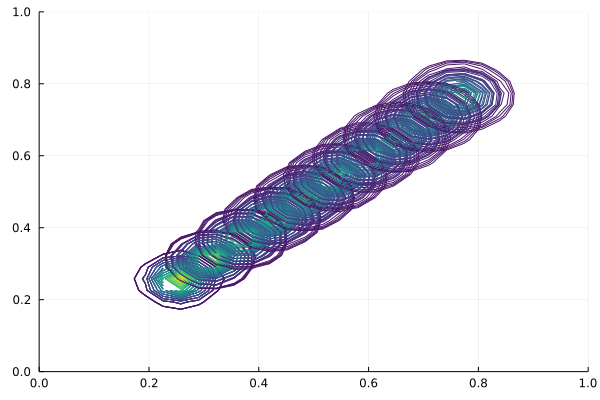

In [22]:
contour(x₁, x₂, p, zlim = [0,c_max], clim = (0,c_max), c=:viridis, legend=:none)

In [23]:
#=anim = @animate for s in 900:1:1000
    surface(x₁, x₂, p[s], zlim = [0,c_max], clim = (0,c_max), c=:viridis, legend=:none)
end
gif(anim, "diffusion.gif", fps=16)=#

In [24]:
ε = 5e-3

SP = SinkhornParameters(32, ε)
SPB = SinkhornParameters(48, ε)

SP.averaged_updates = false
SP.debias = true

k = WassersteinDictionaries.get_gibbs_matrix(c, ε)

α_indices = [ 1, Sₜ ]
α = [ p[s] for s in α_indices ]
S = length(α)

caches = ( MC = MatrixCache(S,n), VMC = VectorMatrixCache(S,n), VC = VectorCache(S,n) )

a₀ = ones(size(α[1])); b₀ = ones(size(α[1]))
d₀₁ = ones(size(α[1])); d₀₂ = ones(size(α[1]))

b_₀ = [ones(size(α[s])) for s in eachindex(α)] 
d₀ = ones(size(α[1]));

x_trace = []
y_trace = [];

In [323]:
function optimcallback(x, loss)

    push!(y_trace, loss(x[end].metadata["x"]) )
    push!(x_trace, softmax(x[end].metadata["x"]))

    if y_trace[end] < 1e-9
        return true
    else
        return false
    end
end

optimcallback (generic function with 1 method)

In [325]:
S

3

In [326]:
ΔW = zeros(Sₜ)
λ = [zeros(S) for _ in 1:Sₜ]

results = []

for s in 1:Sₜ

    q = p[s]

    a₀ .= 1; b₀ .= 1
    d₀₁ .= 1; d₀₂ .= 1

    for s_ in 1:S
        b_₀[s_] .= 1
    end
    d₀ .= 1

    function w2_loss_separated(w::Vector{T}) where T
        μ_λ = sinkhorn_barycenter_separated(softmax(w), α, b_₀, d₀, k, SPB, caches)
        return abs( sinkhorn_dvg_separated(μ_λ, q, a₀, b₀, d₀₁, d₀₂, k, SP, caches) ) #+ sqeuclidean(μ_λ,q)/norm(q)^2
    end

    SP.L = 32
    SPB.L = 48

    brk = false
    for s_α in eachindex(α_indices)
        if s == α_indices[s_α]
            λ[s][s_α] = 1
            ΔW[s] = 0.0
            brk = true
        end
    end

    if brk
        continue
    end

    result = optimize(  w2_loss_separated,
                        zeros(S),                     
                        LBFGS(  #linesearch = LineSearches.BackTracking( c_1=1e-6, iterations = 100),
                                #alphaguess = LineSearches.InitialStatic()
                            ),
                        Optim.Options(  callback = x -> optimcallback(x, w2_loss_separated),
                                        iterations = 48,
                                        allow_f_increases = true,
                                        store_trace = true,
                                        extended_trace = true,
                                        g_tol = 1e-9,
                                        f_tol = 1e-6),
                        autodiff=:forward   )

    push!(results, result)

    wₒₚₜ = Optim.minimizer(result)
    λ[s] = softmax(wₒₚₜ)
    ΔW[s] = Optim.minimum(result)
end

In [327]:
results[1]

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     3.358471e-08

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 3.90e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.77e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.90e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.95e-02 ≰ 1.0e-06
    |g(x)|                 = 4.31e-06 ≰ 1.0e-09

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    48
    f(x) calls:    132
    ∇f(x) calls:   132


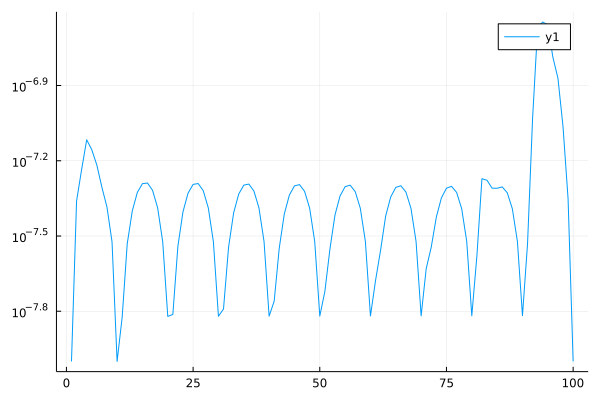

In [328]:
plot(ΔW .+ 1e-8, yaxis=:log)

In [329]:
argmax(ΔW)

94

In [330]:
λ

100-element Vector{Vector{Float64}}:
 [1.0, 0.0, 0.0]
 [0.8888477640809859, 0.010888907717614851, 0.10026332820139922]
 [0.777810176405019, 0.01289438087758309, 0.2092954427173979]
 [0.6666595973033211, 0.01674218182978941, 0.3165982208668895]
 [0.5555552069897345, 0.01365732676620308, 0.43078746624406244]
 [0.4444749772584032, 0.009599498680386025, 0.5459255240612108]
 [0.3333157723607668, 0.003913883467605425, 0.6627703441716278]
 [0.2222144183966196, 0.001912121870224285, 0.775873459733156]
 [0.11111113175527229, 0.00029032205356631103, 0.8885985461911614]
 [0.0, 0.0, 1.0]
 ⋮
 [0.8889622323387915, 0.10790681552367484, 0.0031309521375337147]
 [0.7776654306317432, 0.20999606049216912, 0.012338508876087702]
 [0.6666224574766461, 0.3239744090968847, 0.009403133426469337]
 [0.5555417872233069, 0.4373256131533512, 0.00713259962334189]
 [0.4444722391431384, 0.554350012823254, 0.0011777480336075984]
 [0.3333243921906985, 0.6653569004177102, 0.0013187073915914196]
 [0.22221649635975818, 0.77

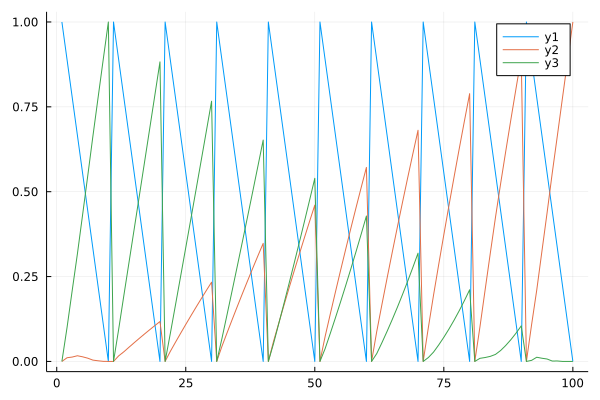

In [331]:
plt = plot( [λ[s][1] for s in eachindex(λ)] )
for i in 2:S
    plot!( [λ[s][i] for s in eachindex(λ)] )
end
plt

In [332]:
pᵣ = copy(p)
SPB.L = 64
for s in 1:Sₜ
    pᵣ[s] = sinkhorn_barycenter_separated(λ[s], α, b_₀, d₀, k, SPB, caches)
end

In [333]:
ΔL₁ = [ norm(p[s]-pᵣ[s],1) for s in 1:Sₜ ];

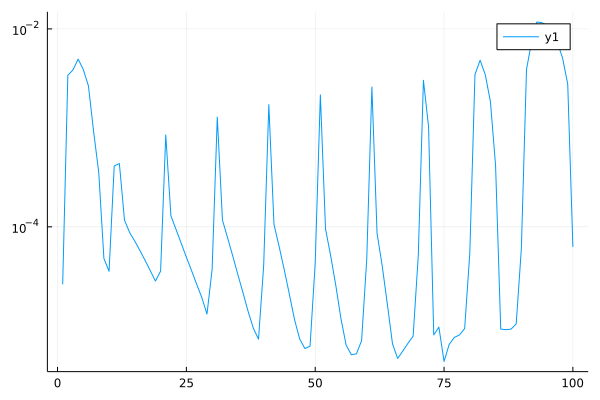

In [334]:
plot(ΔL₁, yaxis=:log)

In [357]:
sum(ΔL₁)./Sₜ, sum(ΔW)./Sₜ

(0.0011906667291873005, 3.646740579072315e-8)

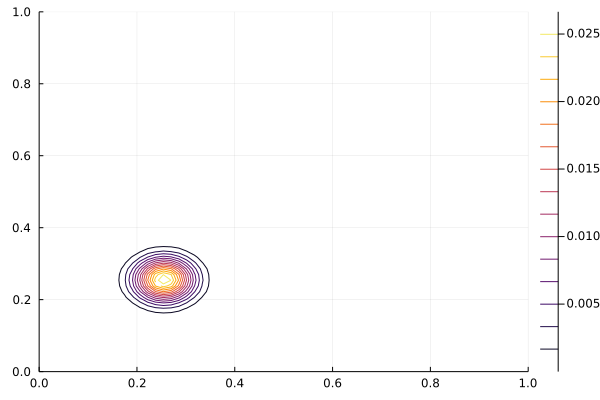

In [336]:
s_ = 1
contour(x₁, x₂, pᵣ[s_])

In [337]:
push!(ΔL1_trace, sum(ΔL₁)./Sₜ)

2-element Vector{Any}:
 0.004064602514600633
 0.0011906667291873005

In [303]:
#ΔL1_trace = []

In [304]:
#pop!(ΔL1_trace)

# SVD

In [338]:
Snap = zeros(n^2,Sₜ)

for s in 1:Sₜ
    Snap[:,s] .= reshape(p[s],n^2)
end

F = svd(Snap);

In [339]:
fieldnames(typeof(F))

(:U, :S, :Vt)

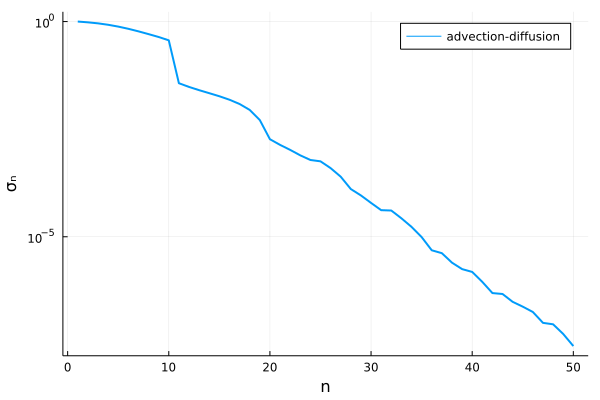

In [340]:
plot(F.S[1:50]./F.S[1], yaxis = :log, linewidth=2, xlab="n", ylab="σₙ", label="advection-diffusion")
#plot!(S_diff[1:50]./S_diff[1], yaxis = :log, linewidth=2, xlab="n", ylab="σₙ", label="pure diffusion")
#savefig("sv_advection_diffusion.png")

In [341]:
modes = [ reshape(F.U[:,s], (n,n)) for s in 1:Sₜ  ];

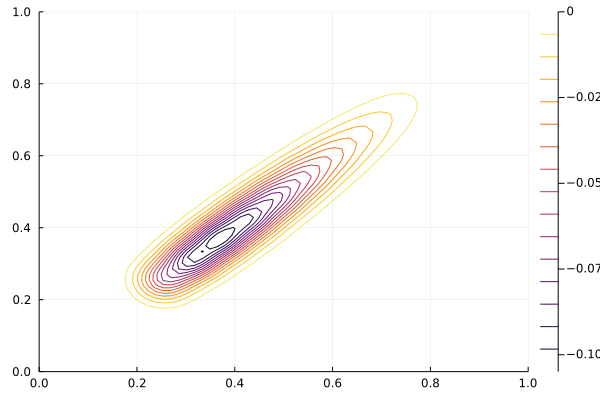

In [342]:
contour(x₁, x₁, modes[1])

In [351]:
ΔL1_trace_svd = []
for ns in 2:30
    pₛᵥ = [ reshape( F.U[:,1:ns] * F.U[:,1:ns]' * Snap[:,s], (n,n)) for s in 1:Sₜ ]
    ΔL₁_svd = [ norm(p[s]-pₛᵥ[s],1) for s in 1:Sₜ ]
    push!(ΔL1_trace_svd, sum(ΔL₁_svd)./Sₜ)
end


In [361]:
ΔL1_trace_svd[19]

0.001191365457427202

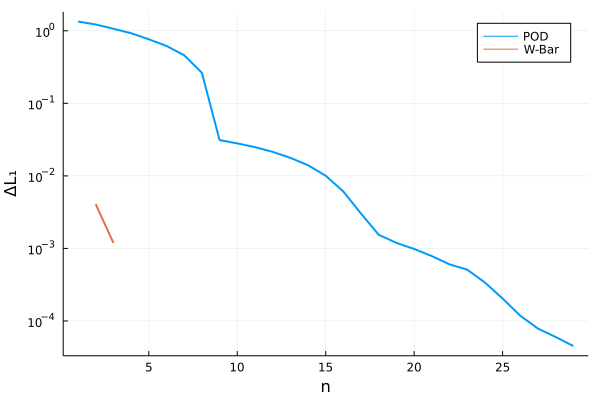

attempt to save state beyond implementation limit


In [359]:
plot(ΔL1_trace_svd, yaxis = :log, linewidth=2, xlab="n", ylab="ΔL₁", label="POD")
plot!(2:3, ΔL1_trace, yaxis = :log, linewidth=2, label="W-Bar")

In [356]:
ΔL1_trace_svd[end-10:end]

11-element Vector{Any}:
 0.001191365457427202
 0.0009821008803159049
 0.0007834483861339444
 0.0006022477521685092
 0.0005091804356072532
 0.0003385212298353087
 0.00020378203789357487
 0.00011796071614526522
 7.85258732405193e-5
 6.006239893791138e-5
 4.5066312971454076e-5

In [346]:
#ΔL1_trace_svd = []

In [347]:
ns = 10
pₛᵥ = [ reshape( F.U[:,1:ns] * F.U[:,1:ns]' * Snap[:,s], (n,n)) for s in 1:Sₜ ];

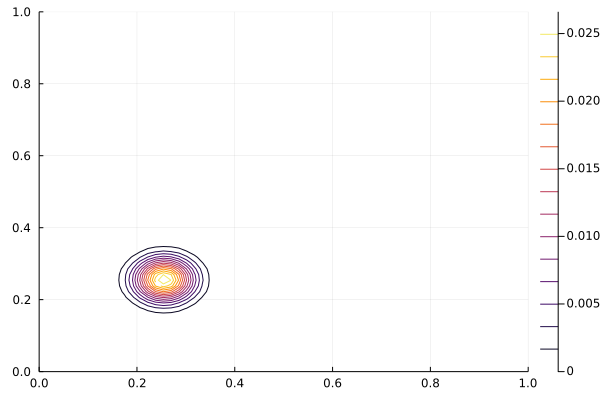

In [348]:
s_ = 11
contour(x₁, x₂, pₛᵥ[s_])